In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

In [ ]:
def deeplabv3_resnet101(pretrained=False, progress=True,
                        num_classes=21, aux_loss=None, **kwargs):
    """Constructs a DeepLabV3 model with a ResNet-101 backbone.

    Args:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017 which
            contains the same classes as Pascal VOC
        progress (bool): If True, displays a progress bar of the download to stderr
        num_classes (int): The number of classes
        aux_loss (bool): If True, include an auxiliary classifier
    """
    return _load_model('deeplabv3', 'resnet101', pretrained, progress, num_classes, aux_loss, **kwargs)

In [ ]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

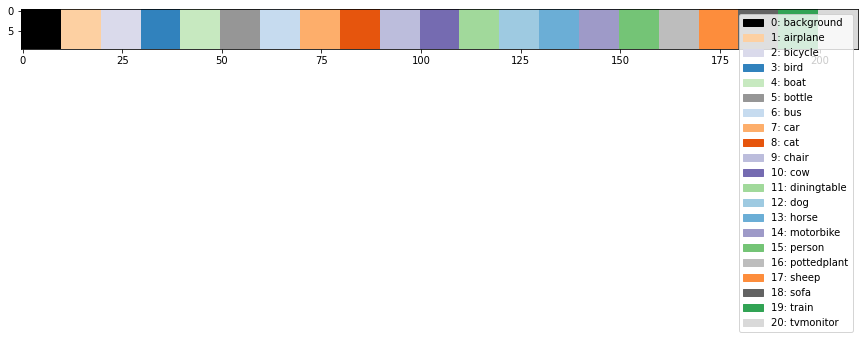

In [ ]:

labels = ['background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(27)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # 배경색
colors = np.array(colors, dtype=np.uint8)

# 컬러 팔레드 생성
palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(15, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)

In [ ]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    # if torch.cuda.is_available():
    #     input_batch = input_batch.to('cuda')
    #     model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving puppy.jpg to puppy (1).jpg
User uploaded file "puppy.jpg" with length 178975 bytes


In [ ]:
ls -al

total 196
drwxr-xr-x 1 root root   4096 Sep 13 09:18 ./
drwxr-xr-x 1 root root   4096 Sep 13 06:56 ../
drwxr-xr-x 4 root root   4096 Sep  1 19:26 .config/
drwxr-xr-x 2 root root   4096 Sep 13 09:00 .ipynb_checkpoints/
-rw-r--r-- 1 root root 178975 Sep 13 08:56 puppy.jpg
drwxr-xr-x 1 root root   4096 Sep  1 19:26 sample_data/


In [ ]:
img = np.array(Image.open('puppy.jpg'))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

RuntimeError: ignored